# Phase 2 Project Notebook -- Jamie Dowat 

#### Project Goals:

* Develop at least 2 variables that are well-modeled with price.
* At least 3 polished visualizations, including a QQ plot

## Business Understanding

* Who are the stakeholders in this project? Who will be directly affected by the creation of this project?
    * If you are struggling to define a stakeholder, we recommend you complete a project for a real estate agency that helps homeowners buy and/or sell homes. A business problem you could focus on for this stakeholder is the need to provide advice to homeowners about how home renovations might increase the estimated value of their homes, and by what amount.


* What business problem(s) will this Data Science project solve for the organization?
    * What factors maximize a home's value?
    

* What problems are inside the scope of this project?
* What problems are outside the scope of this project?
* What data sources are available to us?
* What is the expected timeline for this project? Are there hard deadlines (e.g. "must be live before holiday season shopping") or is this an ongoing project?
* Do stakeholders from different parts of the company or organization all have the exact same understanding about what this project is and isn't?

## Data Understanding

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
from statsmodels.formula.api import ols
import scipy.stats as stats


%matplotlib inline

In [2]:
df = pd.read_csv('../src/kc_house_data.csv')

In [3]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [5]:
len(df)

21597

In [4]:
df.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [68]:
df['price_per_sqft'] = df['price'] / df['sqft_living']

In [69]:
df[df['price_per_sqft']==df['price_per_sqft'].max()]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price_per_sqft
19321,6021500970,4/7/2015,874950.0,2,1.0,1080,4000,1.0,0.0,0.0,...,1080,?,1940,NaN,98117,47.6902,-122.387,1530,4240,810.138889


In [70]:
df[df['price_per_sqft']==df['price_per_sqft'].min()]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price_per_sqft
18248,2891000610,12/11/2014,148900.0,4,1.75,1700,6000,1.0,0.0,0.0,...,1700,0.0,1967,0.0,98002,47.3252,-122.208,1280,6000,87.588235


In [9]:
min(years)

1900

In [10]:
max(years)

2015

In [71]:
df.corr().price

id               -0.017439
price             1.000000
bedrooms          0.309651
bathrooms         0.527350
sqft_living       0.704652
sqft_lot          0.087005
floors            0.258277
waterfront        0.276295
view              0.395766
condition         0.038037
grade             0.667224
sqft_above        0.609168
yr_built          0.053525
yr_renovated      0.122590
zipcode          -0.050212
lat               0.305126
long              0.021390
sqft_living15     0.582167
sqft_lot15        0.081243
price_per_sqft    0.554178
Name: price, dtype: float64

Highest correlations with price: (highest to lowest)
* sqft_living
* grade
* sqft_above
* sqft_living15

In [72]:
df.grade.value_counts()

7     7974
8     5409
9     2320
6     1810
10    1018
11     357
5      212
12      82
4       25
13      13
3        1
Name: grade, dtype: int64

In [73]:
# not a great distribution of condition qualities-- what does a '3' mean?
df.condition.value_counts()

3    12474
4     5058
5     1512
2      152
1       25
Name: condition, dtype: int64

In [74]:
df.yr_built.value_counts()

2014    496
2006    404
2005    395
2007    372
2003    372
       ... 
1901     27
1933     26
1902     24
1935     22
1934     19
Name: yr_built, Length: 116, dtype: int64

Text(0.5, 1.0, 'Year Built vs Average Price')

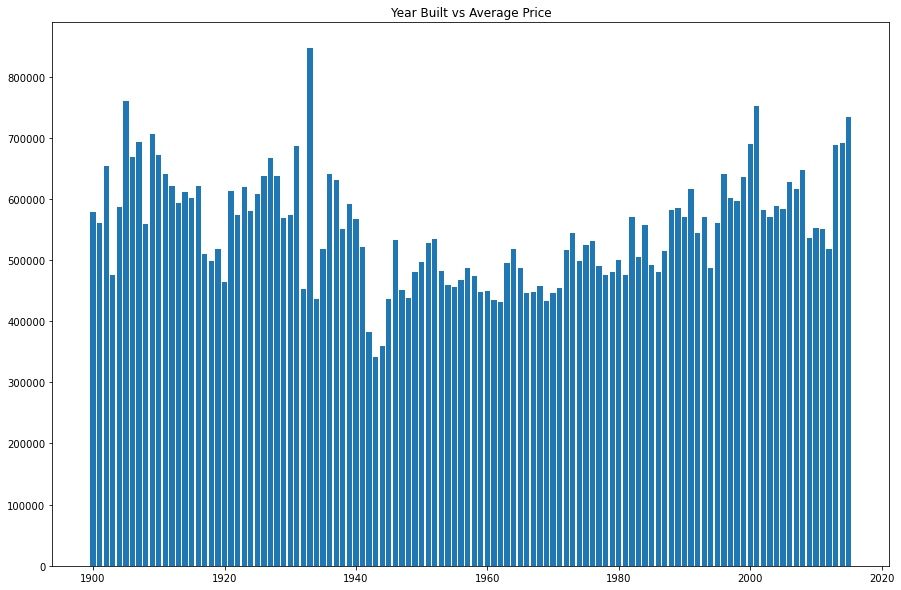

In [75]:
# Avg Sale Price vs Year built
avg_prices = [df['price'][df['yr_built']==year].mean() for year in years]
years = sorted(df.yr_built.value_counts().index)

fig, ax = plt.subplots(figsize=(15,10))
ax.bar(years, avg_prices)
ax.set_title('Year Built vs Average Price')

<AxesSubplot:xlabel='price', ylabel='Count'>

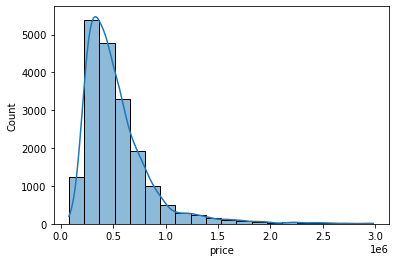

In [76]:
# Distribution of prices
sns.histplot(df['price'][df['price']<3000000], bins=20, kde=True)

<AxesSubplot:xlabel='sqft_living', ylabel='price'>

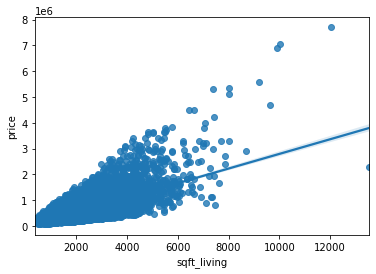

In [77]:
# Distribution of sqft_living and price
sns.regplot(x=df.sqft_living, y=df.price)

In [78]:
mod1 = df[['price', 'sqft_living']]

In [79]:
formula = 'price~sqft_living'
sqft_mod = ols(formula=formula, data=mod1).fit()
sqft_summ = sqft_mod.summary()
sqft_summ

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.497
Model:                            OLS   Adj. R-squared:                  0.497
Method:                 Least Squares   F-statistic:                 1.895e+04
Date:                Sat, 13 Feb 2021   Prob (F-statistic):               0.00
Time:                        12:04:36   Log-Likelihood:            -2.6723e+05
No. Observations:               19221   AIC:                         5.345e+05
Df Residuals:                   19219   BIC:                         5.345e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -5.045e+04   4703.746    -10.726      0.000   -5.97e+04   -4.12e+04
sqft_living   284.3280      2.065    137.675      0.000     280.280     288.376
==============================================================================
Omnibus:                    13337.882   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           507333.623
Skew:                           2.859   Prob(JB):                         0.00
Kurtosis:                      27.511   Cond. No.                     5.62e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.62e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [80]:
df[df['price']>3000000].max()

id                9808700762
date                9/4/2014
price                7.7e+06
bedrooms                   8
bathrooms                  8
sqft_living            12050
sqft_lot               56609
floors                   3.5
waterfront                 1
view                       4
condition                  5
grade                     13
sqft_above              8860
sqft_basement              ?
yr_built                2014
yr_renovated            2010
zipcode                98199
lat                  47.7493
long                -122.077
sqft_living15           5070
sqft_lot15             51330
price_per_sqft       798.122
dtype: object

###### Waterfront views? 

In [81]:
df_wf = df
df_wf.dropna(inplace=True, subset=['waterfront'])

In [82]:
df_wf.isna().sum()

id                   0
date                 0
price                0
bedrooms             0
bathrooms            0
sqft_living          0
sqft_lot             0
floors               0
waterfront           0
view                57
condition            0
grade                0
sqft_above           0
sqft_basement        0
yr_built             0
yr_renovated      3412
zipcode              0
lat                  0
long                 0
sqft_living15        0
sqft_lot15           0
price_per_sqft       0
dtype: int64

In [83]:
df_wf.waterfront.value_counts()

0.0    19075
1.0      146
Name: waterfront, dtype: int64

In [84]:
df_wf['price'][df_wf['waterfront']==1.0].mean()

1717214.7260273972

In [85]:
df_wf['price'][df_wf['waterfront']==0.0].mean()

532641.9866841416

In [86]:
df[df['price']>3000000].max()

id                9808700762
date                9/4/2014
price                7.7e+06
bedrooms                   8
bathrooms                  8
sqft_living            12050
sqft_lot               56609
floors                   3.5
waterfront                 1
view                       4
condition                  5
grade                     13
sqft_above              8860
sqft_basement              ?
yr_built                2014
yr_renovated            2010
zipcode                98199
lat                  47.7493
long                -122.077
sqft_living15           5070
sqft_lot15             51330
price_per_sqft       798.122
dtype: object

In [87]:
df_wf['price'][df_wf['waterfront']==1].max()

7060000.0

Text(0.5, 1.0, 'Comparing CDFs-- price distribution')

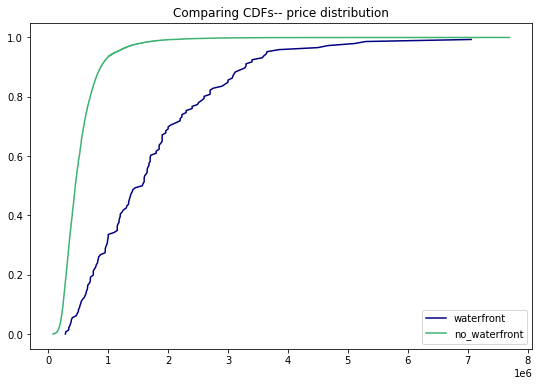

In [88]:
waterfront = df_wf['price'][df_wf['waterfront']==1]
no_waterfront = df_wf['price'][df_wf['waterfront']==0]

plt.figure(figsize=(9, 6))
plt.plot(np.sort(waterfront), np.linspace(0, 1, len(waterfront), endpoint=False), color='navy')
plt.plot(np.sort(no_waterfront), np.linspace(0, 1, len(no_waterfront), endpoint=False), color='mediumseagreen')

plt.legend(['waterfront', 'no_waterfront'])
plt.title('Comparing CDFs-- price distribution')

Text(0.5, 1.0, 'Comparing CDFs-- price distribution')

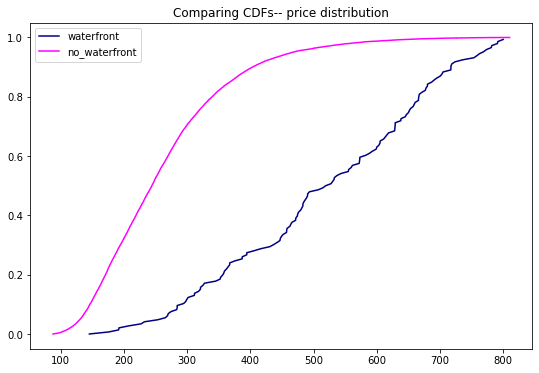

In [89]:
waterfront = df_wf['price_per_sqft'][df_wf['waterfront']==1]
no_waterfront = df_wf['price_per_sqft'][df_wf['waterfront']==0]

plt.figure(figsize=(9, 6))
plt.plot(np.sort(waterfront), np.linspace(0, 1, len(waterfront), endpoint=False), color='navy')
plt.plot(np.sort(no_waterfront), np.linspace(0, 1, len(no_waterfront), endpoint=False), color='magenta')

plt.legend(['waterfront', 'no_waterfront'])
plt.title('Comparing CDFs-- price distribution')

## Data Prep

## Modeling